In [59]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2
import pandas as pd
import numpy as np

import os
os.chdir("..")
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper

os.chdir("/Users/sanjanakotha/Desktop/Staller_Lab/consensus_predictor/notebooks/Yeast TFs")
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")

In [9]:
# 1. Loading in predictor outputs on Lambert TFs
yeast_TFs = pd.read_csv("../../output/yeast_TF_seqs.csv", index_col = 0)
yeast_TFs = yeast_TFs.rename(columns = {"seq" : "sequence"})
yeast_TFs["uniprotID"] = yeast_TFs["id"].str.split("|").str[1]
yeast_TFs["length"] = yeast_TFs["sequence"].str.len()
yeast_TFs

,id,sequence,uniprotID,length
0,sp|O14467|MBF1_YEAST Multiprotein-bridging fac...,MSDWDTNTIIGSRARAGGSGPRANVARSQGQINAARRQGLVVSVDK...,O14467,151
1,sp|O93958|MATA2_YARLL Mating-type protein A2 O...,MENTILHIHSFQLPQTEQPYPEAMLFDRDTSDSRTVLTQKPNGLEI...,O93958,291
2,sp|P03069|GCN4_YEAST General control transcrip...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,P03069,281
3,sp|P04386|GAL4_YEAST Regulatory protein GAL4 O...,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...,P04386,881
4,sp|P04387|GAL80_YEAST Galactose/lactose metabo...,MDYNKRSSVSTVPNAAPIRVGFVGLNAAKGWAIKTHYPAILQLSSQ...,P04387,435
...,...,...,...,...
242,sp|Q707Y3|MATA1_YARLL Mating-type protein A1 O...,MPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISSSLKWFEEI...,Q707Y3,176
243,sp|Q707Y6|MATA1_PICAN Mating-type protein A1 O...,MQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRILEDSLRSER...,Q707Y6,181
244,sp|Q708A1|MATA1_NAKDE Mating-type protein A1 O...,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,Q708A1,122
245,sp|Q9HG12|MATA1_KLULA Mating-type protein A1 O...,MCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPSSKPYFMSW...,Q9HG12,228


In [61]:
all_models["predictor"].value_counts()

predictor
adhunter       452
adpred         321
tada           296
paddle         224
mechanistic    104
Name: count, dtype: int64

In [10]:
adhunter = pd.read_csv("../../output/yeast_TFs_preds/cleaned/adhunter.csv", index_col=0)
adhunter["predictor"] = "adhunter"
adhunter
tada = pd.read_csv("../../output/yeast_TFs_preds/cleaned/tada.csv", index_col=0)
tada["predictor"] = "tada"
tada
adpred = pd.read_csv("../../output/yeast_TFs_preds/cleaned/adpred.csv", index_col=0)
adpred["predictor"] = "adpred"
adpred
mechanistic = pd.read_csv("../../output/yeast_TFs_preds/cleaned/composition.csv", index_col=0)
mechanistic["predictor"] = "mechanistic"
mechanistic
paddle = pd.read_csv("../../output/yeast_TFs_preds/cleaned/paddle_noSS.csv", index_col=0)
paddle["predictor"] = "paddle"
paddle
all_models = pd.concat([adhunter, tada, adpred, mechanistic, paddle])
all_models

def combine_intervals(uniprotID):
    all_models_rows = all_models[all_models["uniprotID"] == uniprotID]
    TF_length = yeast_TFs[yeast_TFs["uniprotID"] == uniprotID]["length"].iloc[0].astype(int)
    
    if len(all_models_rows) > 0:
        preds = []

        for i in range(len(all_models_rows)):
            row_preds = np.zeros(TF_length)
            row = all_models_rows.iloc[i]
            row_preds[row["Start"]:row["End"]] = 1
            preds.append(row_preds)

        all_models_rows["preds"] = preds

        return sum(all_models_rows["preds"]) / 5

    else:
        return np.zeros(TF_length)
        
yeast_TFs_with_preds = yeast_TFs[["uniprotID", "sequence"]]
yeast_TFs_with_preds["combined_preds"] = yeast_TFs_with_preds["uniprotID"].apply(lambda id: combine_intervals(id))
yeast_TFs_with_preds

,uniprotID,sequence,combined_preds
0,O14467,MSDWDTNTIIGSRARAGGSGPRANVARSQGQINAARRQGLVVSVDK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,O93958,MENTILHIHSFQLPQTEQPYPEAMLFDRDTSDSRTVLTQKPNGLEI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P03069,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,P04386,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P04387,MDYNKRSSVSTVPNAAPIRVGFVGLNAAKGWAIKTHYPAILQLSSQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
242,Q707Y3,MPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISSSLKWFEEI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
243,Q707Y6,MQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRILEDSLRSER...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
244,Q708A1,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
245,Q9HG12,MCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPSSKPYFMSW...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
yeast_TFs_with_preds["len"] = yeast_TFs_with_preds["sequence"].str.len()
yeast_TFs_with_preds = yeast_TFs_with_preds.sort_values(by = 'len')
yeast_TFs_with_preds

,uniprotID,sequence,combined_preds,len
26,P11633,MAATKEAKQPKEPKKRTTRRKKDPNAPKRGLSAYMFFANENRDIVR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",99
23,P0CY12,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119
24,P0CY13,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119
134,P40569,MSTKLPIVISNGTAFKKVPVQLLLNSGSEAQHGLPRNADSQPARPR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",121
244,Q708A1,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",122
...,...,...,...,...
114,P39113,MANNNSDRQGLEPRVIRTLGSQALSGPSISNRTSSSEANPHFSKNV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1433
169,P53094,MPLLQPSTCFCYPLKLPPLPLTSDSNEFDECARKRLTLDYRTGSAV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1487
19,P0CE41,MSNTPYNSSVPSIASMTQSSVSRSPNMHTATTPGANTSSNSPPLHM...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1502
176,P53552,MAEQTLLSKLNALSQKVIPPASPSQASILTEEVIRNWPERSKTLCS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1597


In [20]:
known_ADs = pd.read_excel("../../data/sanborn_known_ADs_elife-68068-fig1-data2-v3.xlsx")
known_ADs  = known_ADs.rename(columns = {"protein ID": "uniprotID", "start" : "Start", "stop" : "End"})
known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...
...,...,...,...,...,...,...,...,...
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS
148,HAA1,Q12753,274,335,28.366703,8.207702,A_tiles_Q12753:282,NSRVGEVSVPLEEYIPSDIDGVGRVTDKSSLVYDWPFDESIERNFS...


In [26]:
known_ADs["charge"] = known_ADs["sequence"].str.count("R") +  known_ADs["sequence"].str.count("K") -  known_ADs["sequence"].str.count("D") -  known_ADs["sequence"].str.count("E")
known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence,charge
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...,-15
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK,-4
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,-10
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...,-4
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...,-8
...,...,...,...,...,...,...,...,...,...
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT,-8
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...,-6
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS,-5
148,HAA1,Q12753,274,335,28.366703,8.207702,A_tiles_Q12753:282,NSRVGEVSVPLEEYIPSDIDGVGRVTDKSSLVYDWPFDESIERNFS...,-7


In [27]:
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]
acidic_known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence,charge
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...,-15
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK,-4
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,-10
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...,-4
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...,-8
...,...,...,...,...,...,...,...,...,...
144,YLL054C,Q12244,777,842,108.571140,11.500851,A_tiles_Q12244:790,SLDLEILEELEKLISAQEFSRNFTEDVDESLQSEIDLMNYDNEALN...,-13
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT,-8
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...,-6
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS,-5


In [21]:
def combine_known_intervals(uniprotID):
    known_ADs_rows = known_ADs[known_ADs["uniprotID"] == uniprotID]
    TF_length = yeast_TFs[yeast_TFs["uniprotID"] == uniprotID]["length"].iloc[0].astype(int)
    
    if len(known_ADs_rows) > 0:
        annots = []

        for i in range(len(known_ADs_rows)):
            row_annots = np.zeros(TF_length)
            row = known_ADs_rows.iloc[i]
            row_annots[row["Start"]:row["End"]] = 1
            annots.append(row_annots)

        known_ADs_rows["annots"] = annots

        return np.array(sum(known_ADs_rows["annots"]))

    else:
        return np.zeros(TF_length)
        

In [22]:
yeast_TFs_with_preds["combined_annots"] = yeast_TFs_with_preds["uniprotID"].apply(lambda id: combine_known_intervals(id))
yeast_TFs_with_preds

,uniprotID,sequence,combined_preds,len,combined_annots
26,P11633,MAATKEAKQPKEPKKRTTRRKKDPNAPKRGLSAYMFFANENRDIVR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23,P0CY12,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,P0CY13,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134,P40569,MSTKLPIVISNGTAFKKVPVQLLLNSGSEAQHGLPRNADSQPARPR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
244,Q708A1,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",122,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
114,P39113,MANNNSDRQGLEPRVIRTLGSQALSGPSISNRTSSSEANPHFSKNV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1433,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,P53094,MPLLQPSTCFCYPLKLPPLPLTSDSNEFDECARKRLTLDYRTGSAV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1487,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,P0CE41,MSNTPYNSSVPSIASMTQSSVSRSPNMHTATTPGANTSSNSPPLHM...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
176,P53552,MAEQTLLSKLNALSQKVIPPASPSQASILTEEVIRNWPERSKTLCS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
acidic_activator_TFs = yeast_TFs_with_preds[yeast_TFs_with_preds["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
acidic_activator_TFs

,uniprotID,sequence,combined_preds,len,combined_annots
40,P15315,MVVINGVKYACETCIRGHRAAQCTHTDGPLQMIRRKGRPSTTCGHC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
142,P41546,MEMTDFELTSNSQSNLAIPTNFKSTLPPRKRAKTKEEKEQRRIERI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",238,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52,P21705,MDESVDPVELLLRLLIRHKPHLKPYAYRQDSWQRVLDEYNRQTGSR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",255,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P03069,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",281,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78,P33122,MNSILDRNVRSSETTLIKPESEFDNWLSDENDGASHINVNKDSSSV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",291,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
206,Q04545,MSSEEFKGLPIKRDISSTIYADRPPALSAPPCVGATGNDKIQVLPI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1251,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,P07248,MANVEKPNDCSGFPVVDLNSCFSNGFNNEKQEIEMETDDSPILLMS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, ...",1323,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
158,P46974,MEPFAFGRGAPALCILTAAARINLDNFVPCCWALFRLSFFFPLDPA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1380,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
114,P39113,MANNNSDRQGLEPRVIRTLGSQALSGPSISNRTSSSEANPHFSKNV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1433,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Visualization

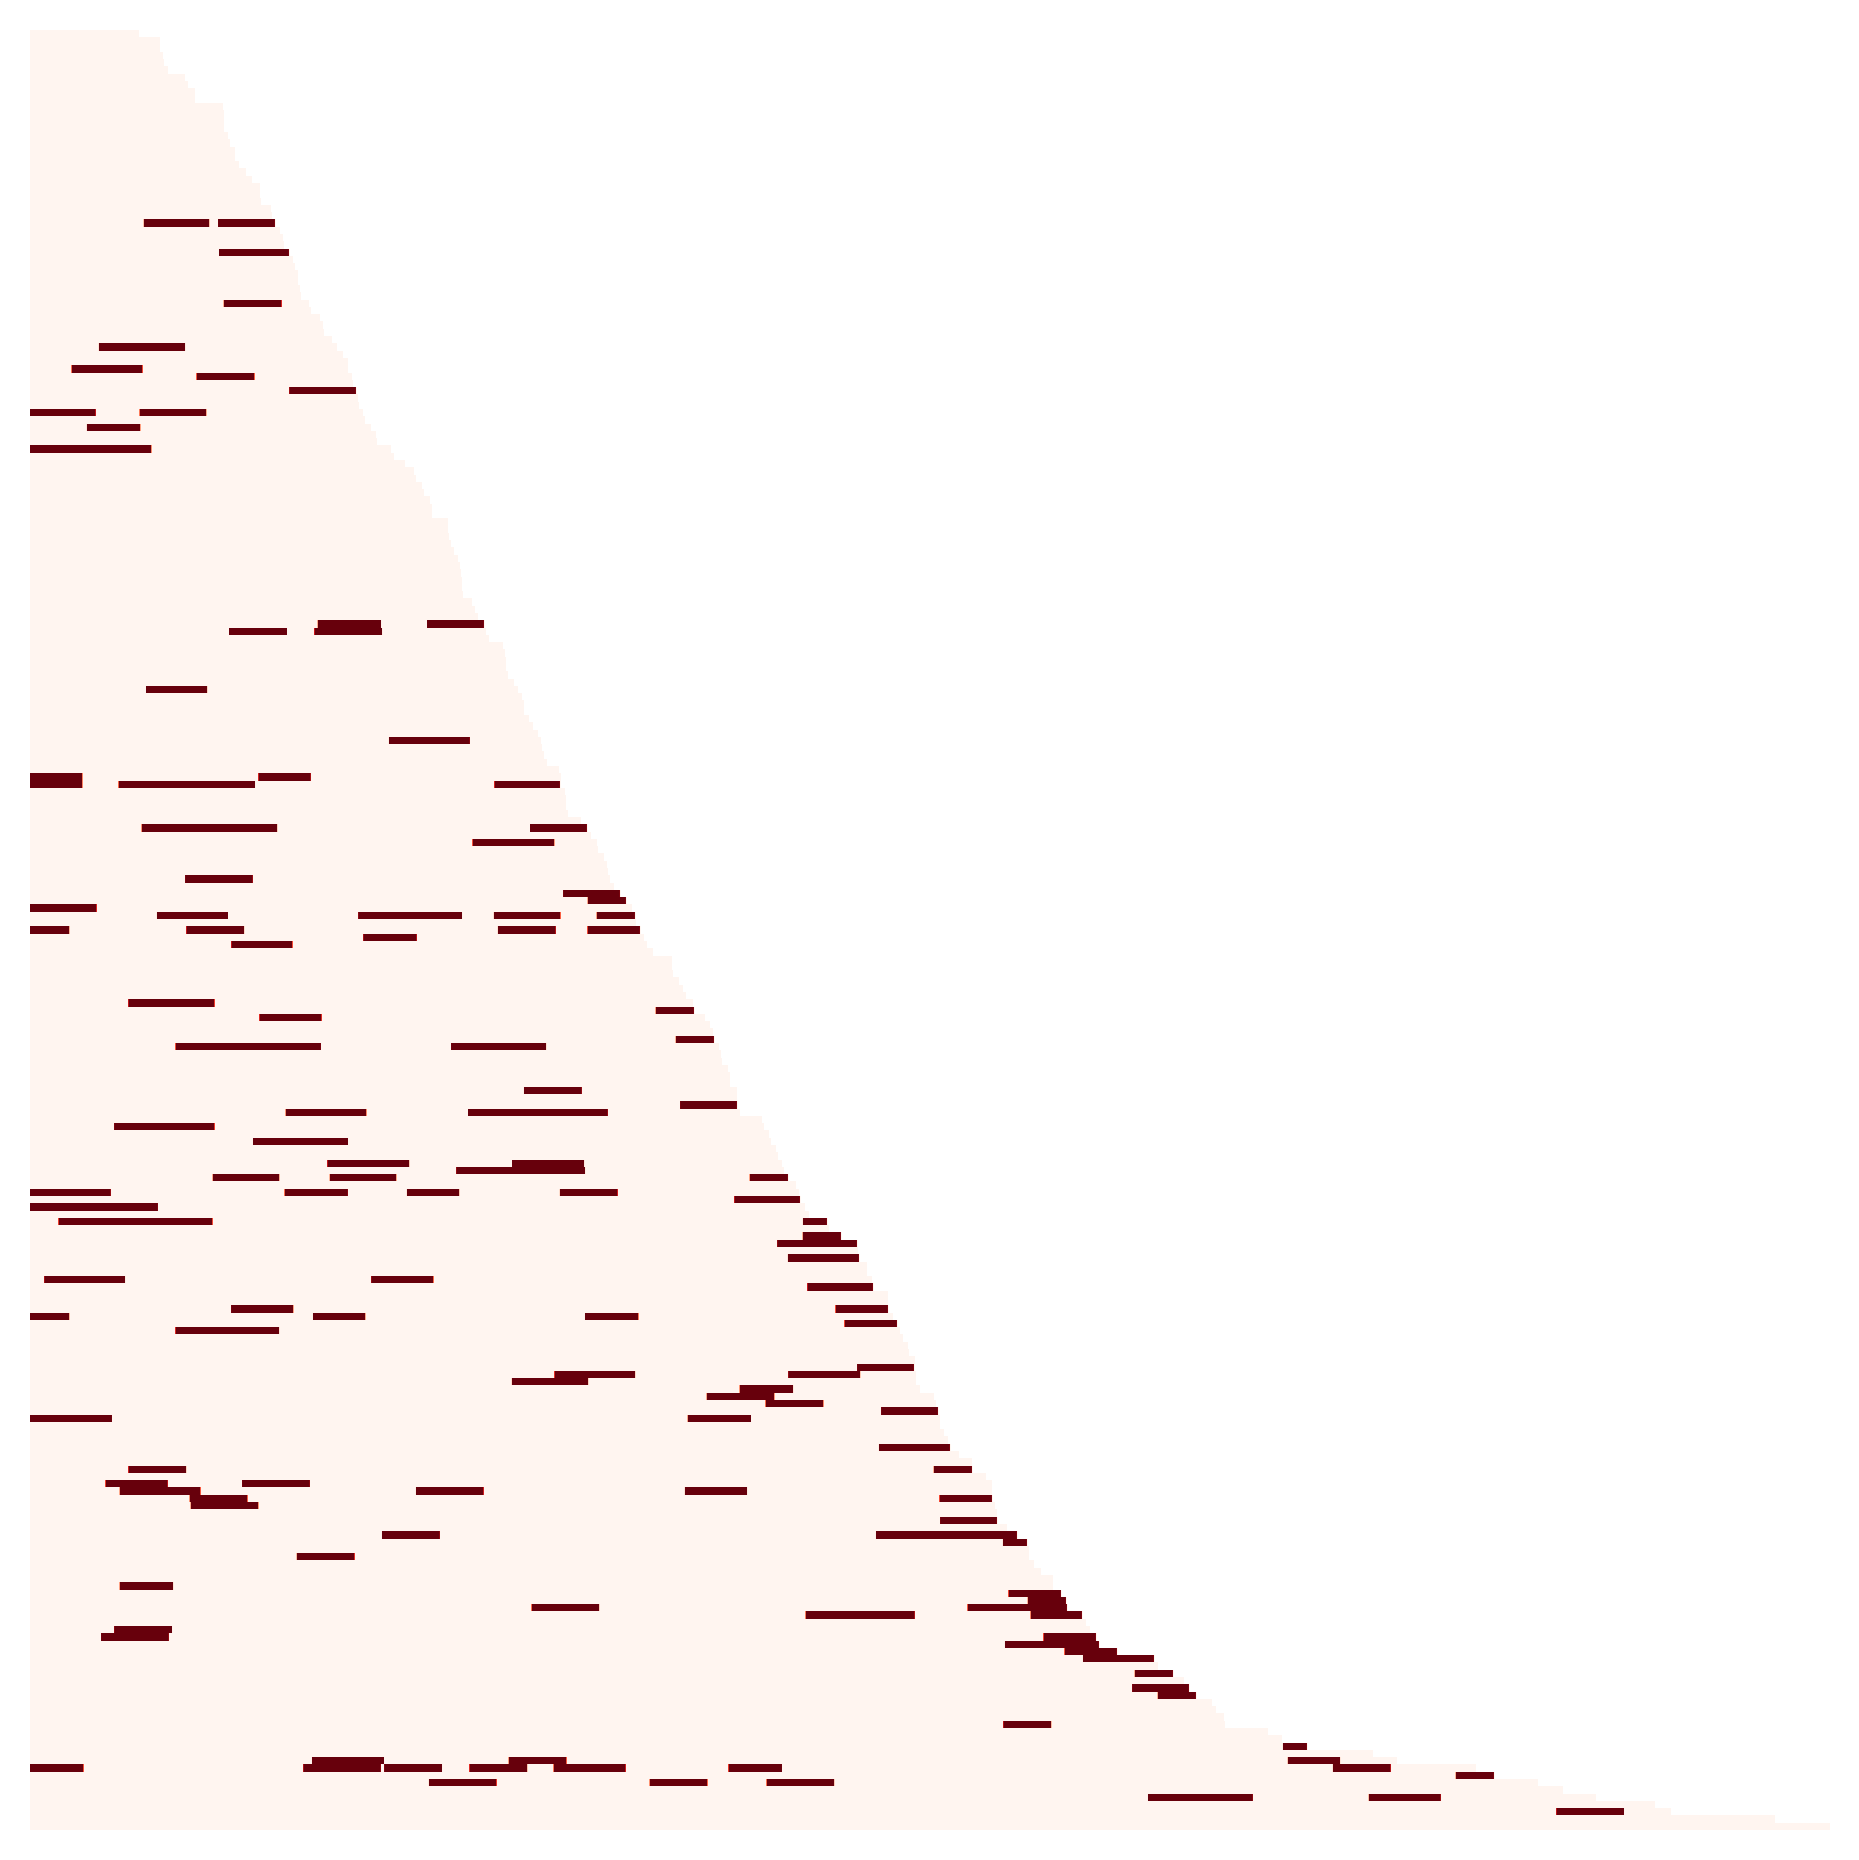

In [23]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = yeast_TFs_with_preds['combined_annots'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(yeast_TFs_with_preds), 1, figsize = (6,6), sharex = True)
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Reds', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

In [39]:
yeast_TFs_with_preds

,uniprotID,sequence,combined_preds,len,combined_annots
26,P11633,MAATKEAKQPKEPKKRTTRRKKDPNAPKRGLSAYMFFANENRDIVR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23,P0CY12,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,P0CY13,MRSIENDRSNYQLTQKNKSADGLVFNVVTQDMINKSTKPYRGHRFT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134,P40569,MSTKLPIVISNGTAFKKVPVQLLLNSGSEAQHGLPRNADSQPARPR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
244,Q708A1,MNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVINSLDIDPDS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",122,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
114,P39113,MANNNSDRQGLEPRVIRTLGSQALSGPSISNRTSSSEANPHFSKNV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1433,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,P53094,MPLLQPSTCFCYPLKLPPLPLTSDSNEFDECARKRLTLDYRTGSAV...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1487,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,P0CE41,MSNTPYNSSVPSIASMTQSSVSRSPNMHTATTPGANTSSNSPPLHM...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
176,P53552,MAEQTLLSKLNALSQKVIPPASPSQASILTEEVIRNWPERSKTLCS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence,charge,pred_overlap_count
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...,-15,4
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK,-4,3
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,-10,4
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...,-4,3
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...,-8,2
...,...,...,...,...,...,...,...,...,...,...
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT,-8,3
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...,-6,2
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS,-5,2
148,HAA1,Q12753,274,335,28.366703,8.207702,A_tiles_Q12753:282,NSRVGEVSVPLEEYIPSDIDGVGRVTDKSSLVYDWPFDESIERNFS...,-7,2


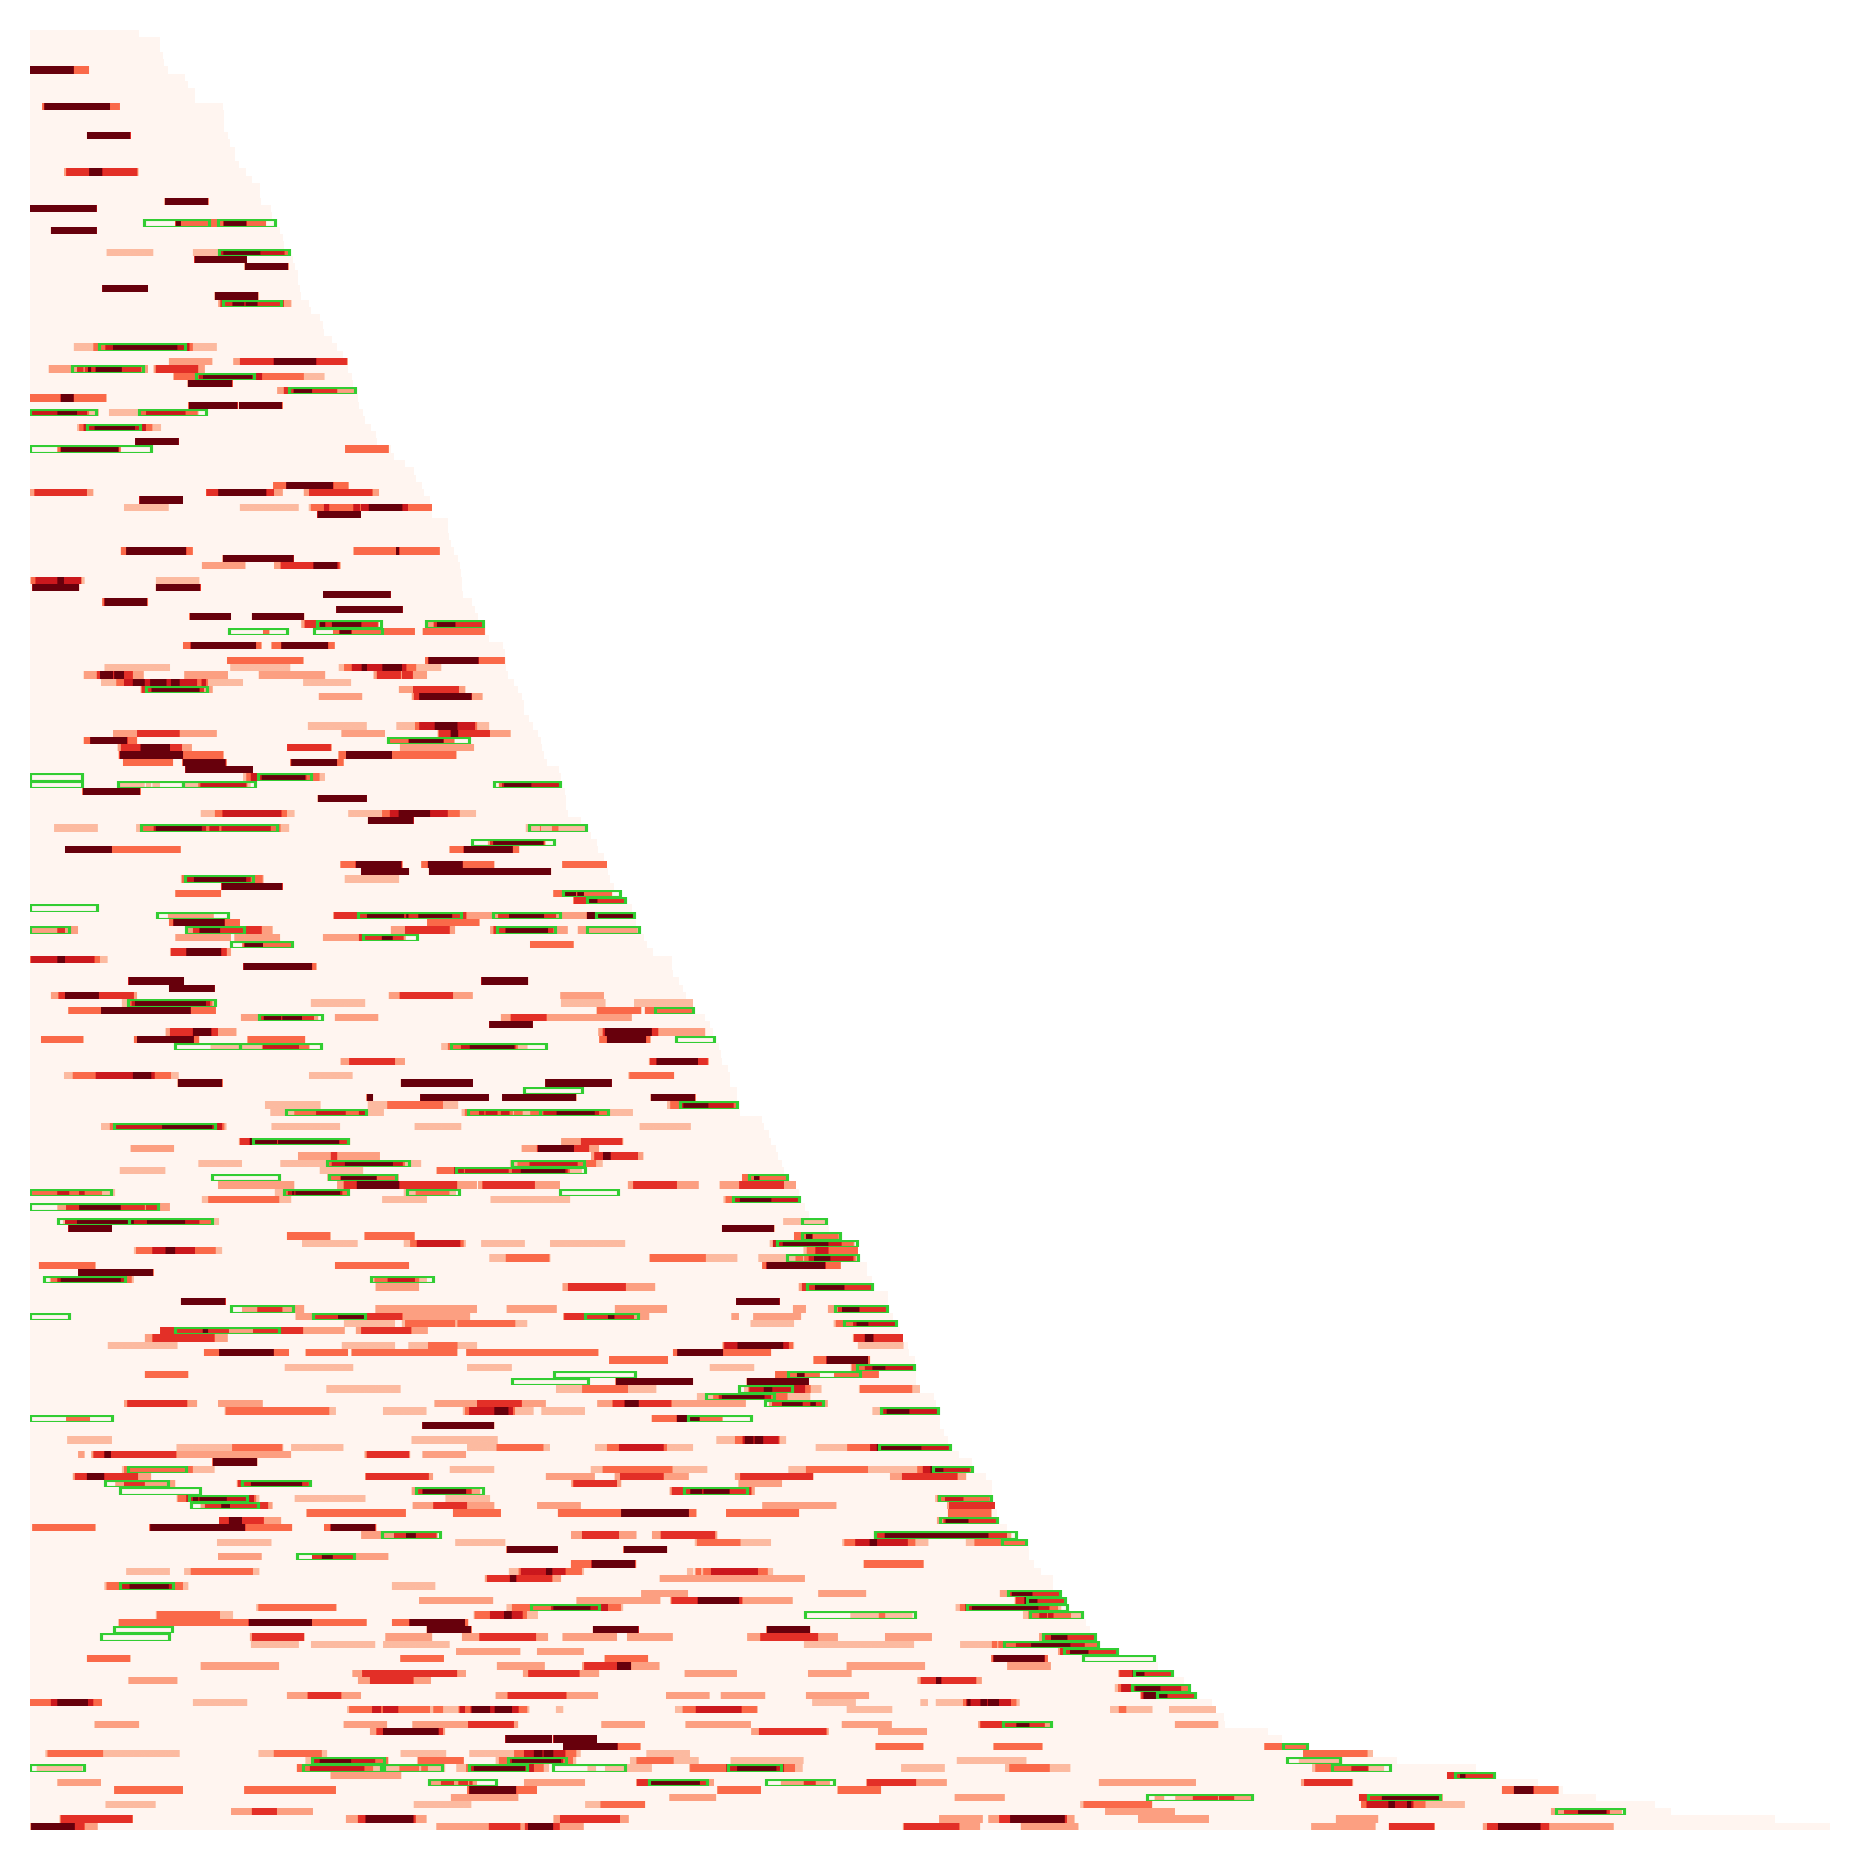

In [47]:
import matplotlib.patches as patches

# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = yeast_TFs_with_preds['combined_preds'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(yeast_TFs_with_preds), 1, figsize = (6,6), sharex = True)



for i in range(len(axs)):
    uniprotID = yeast_TFs_with_preds["uniprotID"].iloc[i]

    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Reds', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

    AD_rows = known_ADs[known_ADs["uniprotID"] == uniprotID]
        # Add rectangle(s) for each interval
    for (start, end) in zip(AD_rows["Start"], AD_rows["End"]):
        width = end - start
        rect = patches.Rectangle(
            (start, 0),  # (x, y) lower-left corner
            width,
            1,  # height
            linewidth=0.75,
            edgecolor='limegreen',
            facecolor='none'
        )
        ax.add_patch(rect)

sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

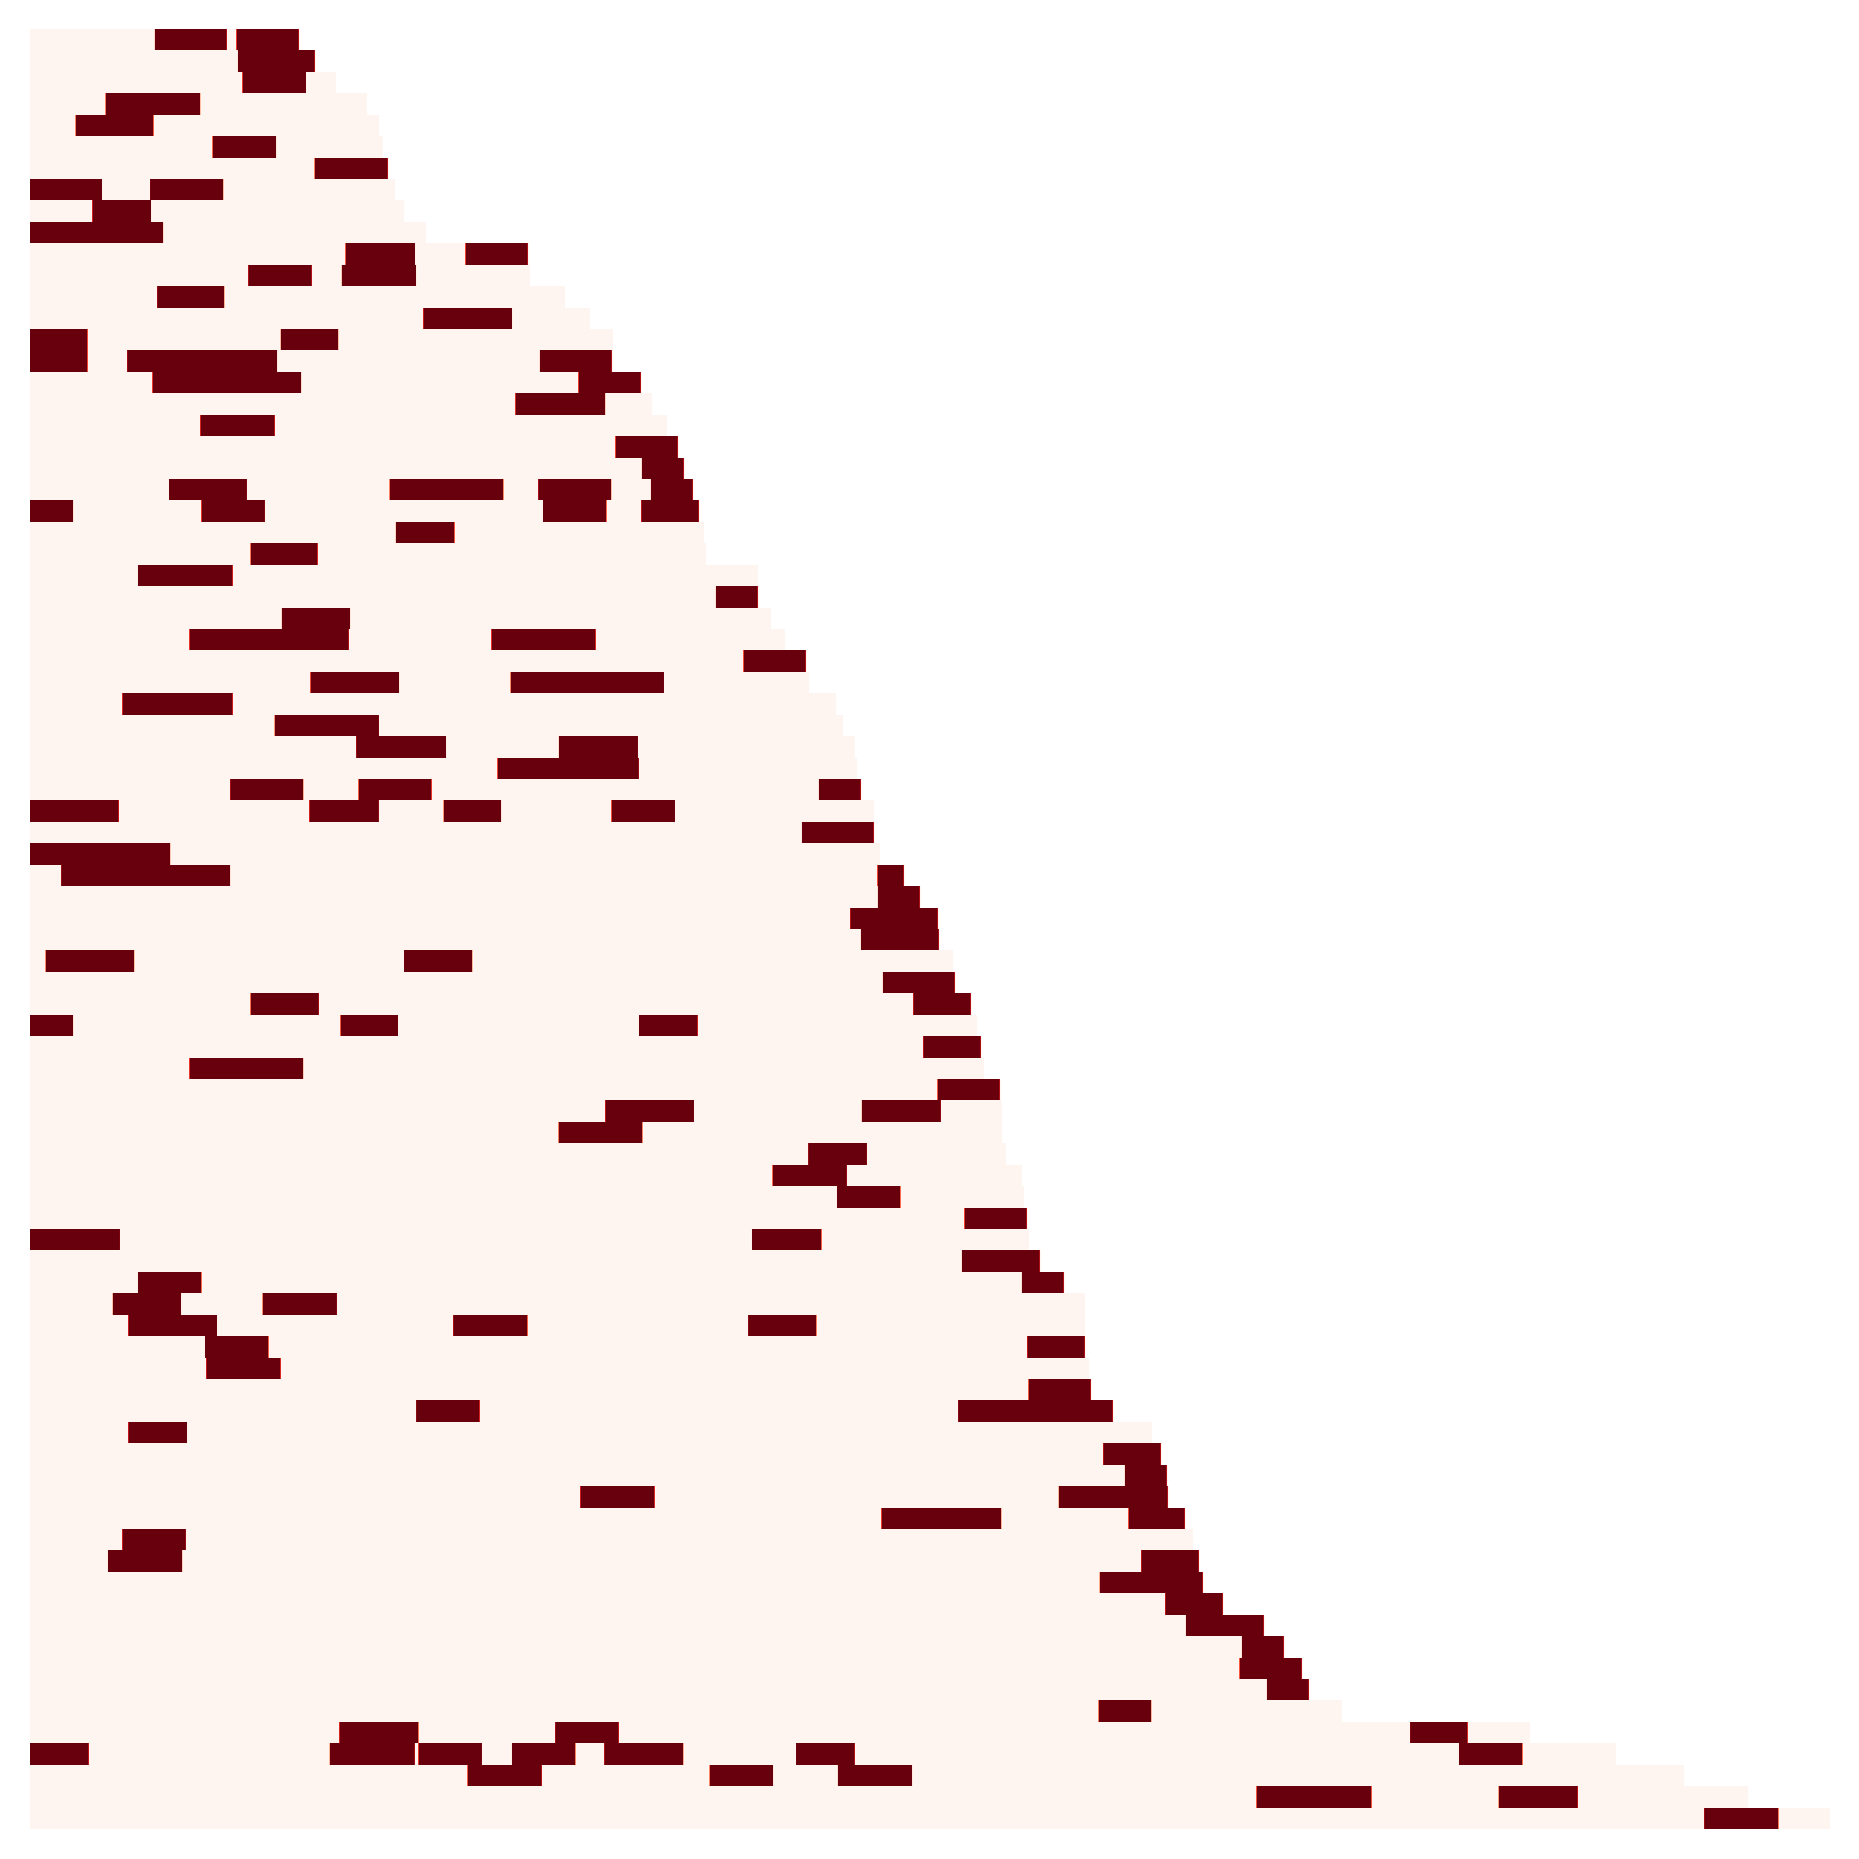

In [29]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TFs['combined_annots'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TFs), 1, figsize = (6,6), sharex = True)
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Reds', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

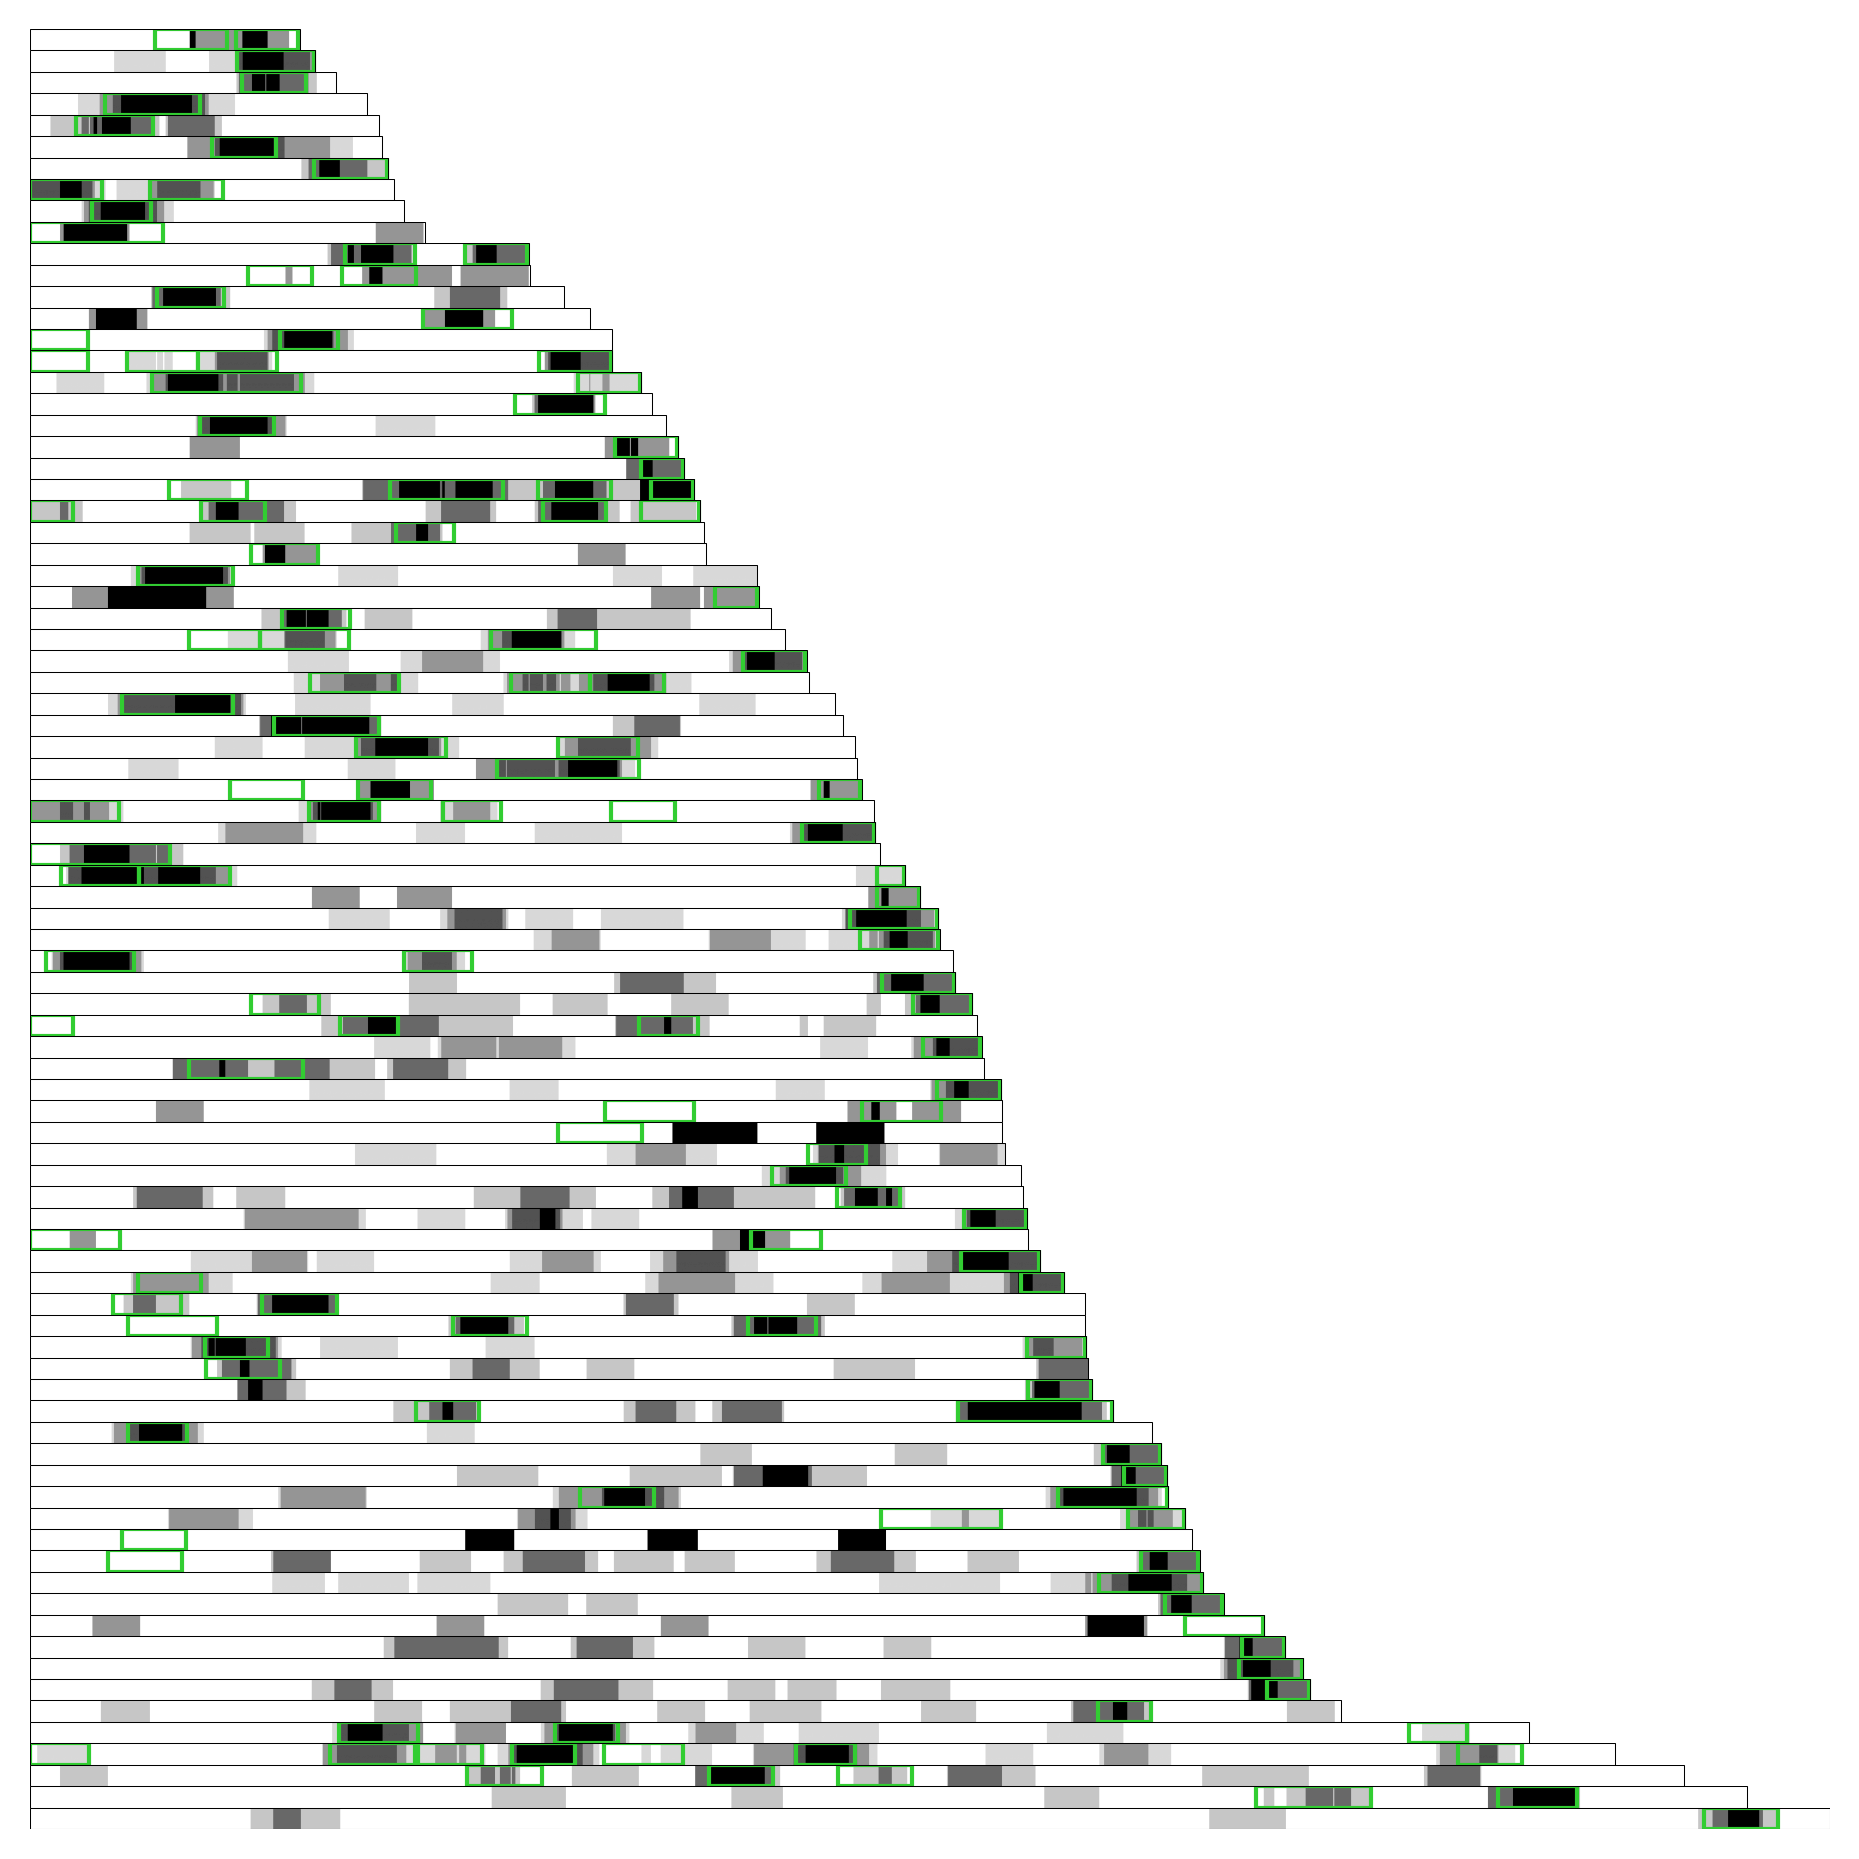

In [58]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TFs['combined_preds'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TFs), 1, figsize = (6,6), sharex = True)

for i in range(len(axs)):
    uniprotID = acidic_activator_TFs["uniprotID"].iloc[i]

    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Grays', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

    AD_rows = known_ADs[known_ADs["uniprotID"] == uniprotID]
        # Add rectangle(s) for each interval
    for (start, end) in zip(AD_rows["Start"], AD_rows["End"]):
        width = end - start
        rect = patches.Rectangle(
            (start, 0),  # (x, y) lower-left corner
            width,
            1,  # height
            linewidth=1,
            edgecolor='limegreen',
            facecolor='none'
        )
        ax.add_patch(rect)

    rect = patches.Rectangle(
            (0, 0),  # (x, y) lower-left corner
            len(data[i]),
            1,  # height
            linewidth=0.25,
            edgecolor='black',
            facecolor='none'
        )
    ax.add_patch(rect)
    
sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

# Table

In [31]:
def count_overlaps(row, df2):
    # Filter df2 by matching uniprotID
    matching_rows = df2[df2['uniprotID'] == row['uniprotID']]
    
    # Count overlaps: intervals overlap if
    # start1 < end2 AND end1 > start2
    overlaps = matching_rows[((matching_rows['Start'] < row['End']) & (matching_rows['End'] > row['Start']))]
    
    return len(overlaps["predictor"].unique())


In [32]:
known_ADs['pred_overlap_count'] = known_ADs.apply(count_overlaps, axis=1, df2=all_models)
known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence,charge,pred_overlap_count
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...,-15,4
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK,-4,3
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,-10,4
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...,-4,3
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...,-8,2
...,...,...,...,...,...,...,...,...,...,...
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT,-8,3
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...,-6,2
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS,-5,2
148,HAA1,Q12753,274,335,28.366703,8.207702,A_tiles_Q12753:282,NSRVGEVSVPLEEYIPSDIDGVGRVTDKSSLVYDWPFDESIERNFS...,-7,2


In [34]:
max(known_ADs["pred_overlap_count"])

4

In [37]:
acidic_known_ADs['pred_overlap_count'] = acidic_known_ADs.apply(count_overlaps, axis=1, df2=all_models)
acidic_known_ADs

,protein,uniprotID,Start,End,maximal activation,maximal Z score,maximal fragment,sequence,charge,pred_overlap_count
0,GCN4,P03069,63,142,128.273405,11.910003,A_tiles_P03069:76,NLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFE...,-15,4
1,GAL4,P04386,832,880,44.019965,9.285866,A_tiles_P04386:828,SKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKK,-4,3
2,GAL4,P04386,146,199,59.660889,10.031831,A_controls-mean_GAL4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,-10,4
3,ARG81,P05085,194,256,32.070085,8.508774,A_tiles_P05085:194,KGHVKTGILSANDGVPPTPNLLDYDWNNLNITGYEWISSELRDDAL...,-4,3
4,ARG81,P05085,69,126,13.391200,6.366012,A_tiles_P05085:65,IPQNSPATTTNLSGSVDEPQYQRRNIDFVRYDEEYVYHEDMDDELT...,-8,2
...,...,...,...,...,...,...,...,...,...,...
144,YLL054C,Q12244,777,842,108.571140,11.500851,A_tiles_Q12244:790,SLDLEILEELEKLISAQEFSRNFTEDVDESLQSEIDLMNYDNEALN...,-13,4
145,YRM1,Q12340,737,785,73.486889,10.543228,A_tiles_Q12340:733,SENASHNNETGPIETELAQTISNEFWTAYNLGWEELMSQPDYKYLFDT,-8,3
146,YRM1,Q12340,184,241,21.275056,7.501859,A_tiles_Q12340:193,PLEKTGSDILQQVCNVLPSFEQSSKIITDFFNTELETNEVSEVLDK...,-6,2
147,HAA1,Q12753,658,693,35.587427,8.764113,A_tiles_Q12753:641,DLPDTSPMSSIQTASPPSQLLTDQGFADLDNFMSS,-5,2


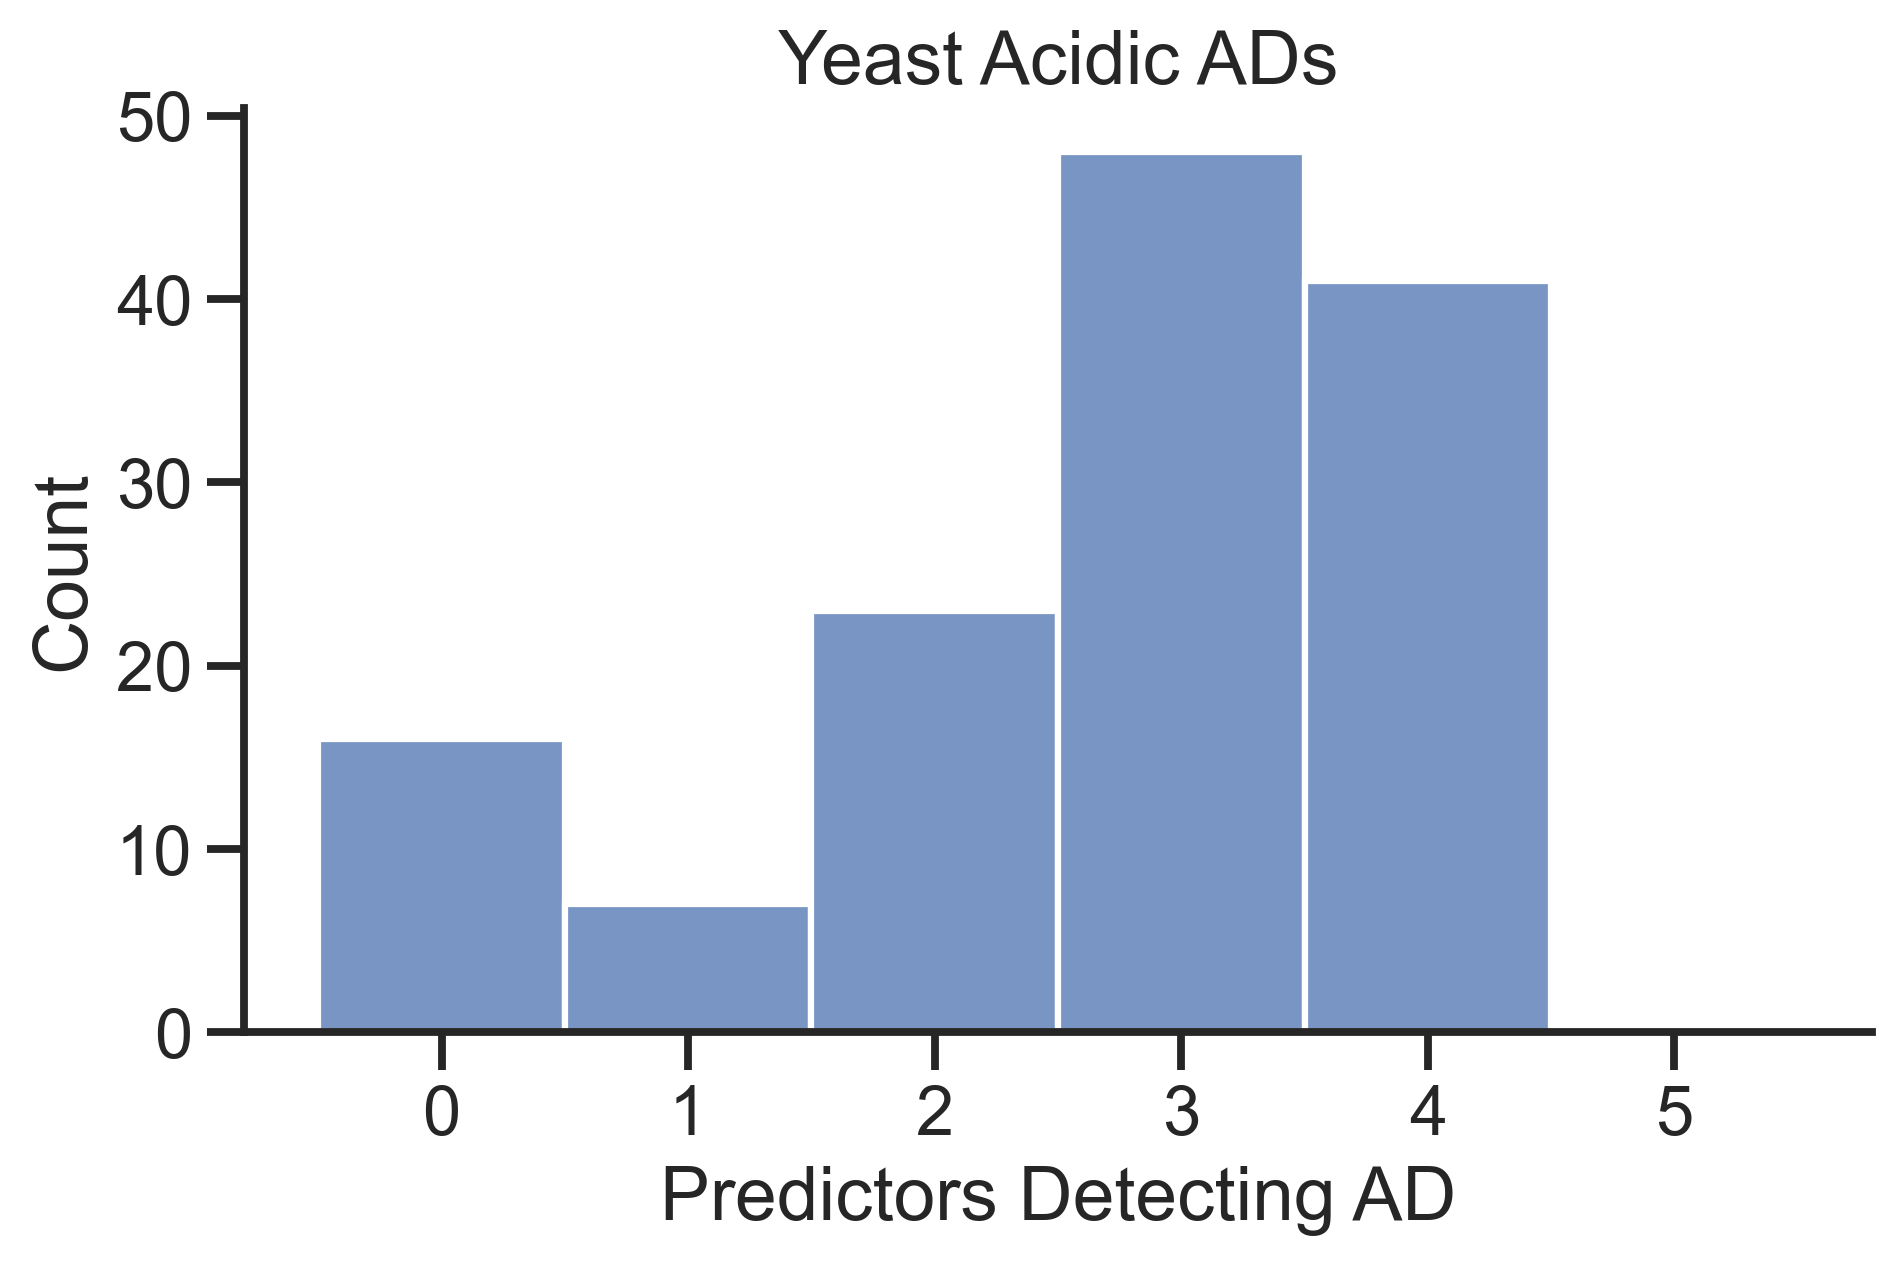

In [38]:
sns.set_context('talk')
sns.set_style('ticks')
plt.figure(figsize=(7, 4))
sns.histplot(acidic_known_ADs["pred_overlap_count"], bins = np.arange(-0.5, 6.5,1))
plt.xlabel("Predictors Detecting AD")
plt.title("Yeast Acidic ADs")
sns.despine()